In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU

Using TensorFlow backend.


In [3]:
# REQUIRED FUNCTION

def shift(df, obj, step=1):
    '''
    '''
    df = pd.concat([df.shift(step), df[obj]], axis=1)
    df = df.dropna()
#     df = df.sample(df.shape[0])
    df = df.values
#     time = df[:, 0]
    X, y = df[:, :-1], df[:, -1]
    return X, y

def scale(train, valid, feature_range=(0, 1)):
    '''
    '''
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    valid_scaled = scaler.transform(valid)
    
    return scaler, train_scaled, valid_scaled

def inverse(scaler, fea, y_pred):
    '''
    '''
    array    = np.c_[fea, y_pred]
    inverted = scaler.inverse_transform(array)
    return inverted[:, -1]

def to_DF(col_name, *args):
    '''
    '''
    assert len(args) != 0, "There are no input data."
    
    df_list = list()
    for arg in args:
        df = pd.DataFrame(data=arg, columns = col_name)
        df_list.append(df)

    return df_list

def MASE(pred, target, orig):
    '''
    '''
    n     = len(target)
    MAE   = np.mean(sum(np.abs(target - pred)))
    MAE_n = np.mean(sum(np.abs(target - orig)))
    e     = MAE / ((n + 1) * MAE_n / n)
    return e

def MAPE(pred, orig):
    '''
    '''
    e = np.mean(np.abs((orig - pred)/orig))
    return e

In [2]:
w2 = pd.read_csv('w2-cali.csv')
w2['date'] = pd.to_datetime(w2['date'])
w = w2.drop(['date'], axis=1)

mtrain, mtest = w[:250], w[250:]

In [5]:
des = w2.describe()
des.to_csv('w2-describe.csv')

## WHFT

In [129]:
scaler, train, test = scale(mtrain, mtest)
cols = w.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(250, 6) (67, 6)


In [130]:
vf_whft = test.values[-1].reshape((1, -1))
vf_whft

array([[-0.1080062 , -0.05594406,  0.68692978,  0.05249917,  0.9882789 ,
         0.10779436]])

In [131]:
X_tr1, y_tr1 = shift(train, 'whft', step=1)
X_te1, y_te1 = shift(test, 'whft', step=1)
print(X_tr1.shape, y_tr1.shape, X_te1.shape, y_te1.shape)

(249, 6) (249,) (66, 6) (66,)


In [29]:
m1 = Sequential()
m1.add(Dense(7, input_shape=(6, ), activation='linear'))
m1.add(LeakyReLU(alpha=0.001))
m1.add(Dense(1))
m1.compile(loss='mse', optimizer='rmsprop')

In [30]:
epochs = 50
h1 = m1.fit(X_tr1, y_tr1, 
             epochs=epochs,
             batch_size=4)

Epoch 1/50
249/249 [==============================] - 0s 2ms/step - loss: 0.3154
Epoch 2/50
249/249 [==============================] - 0s 470us/step - loss: 0.0922
Epoch 3/50
249/249 [==============================] - 0s 413us/step - loss: 0.0661
Epoch 4/50
249/249 [==============================] - 0s 429us/step - loss: 0.0536
Epoch 5/50
249/249 [==============================] - 0s 458us/step - loss: 0.0442
Epoch 6/50
249/249 [==============================] - 0s 425us/step - loss: 0.0368
Epoch 7/50
249/249 [==============================] - 0s 470us/step - loss: 0.0310
Epoch 8/50
249/249 [==============================] - 0s 417us/step - loss: 0.0267
Epoch 9/50
249/249 [==============================] - 0s 454us/step - loss: 0.0231
Epoch 10/50
249/249 [==============================] - 0s 454us/step - loss: 0.0204
Epoch 11/50
249/249 [==============================] - 0s 458us/step - loss: 0.0182
Epoch 12/50
249/249 [==============================] - 0s 413us/step - loss: 0.0168
Epo

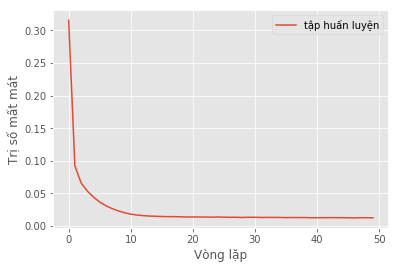

In [31]:
plt.plot(h1.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [33]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                    'loss': h1.history['loss']})
loss.to_csv('w2-whft-loss.dat', index=False)

In [34]:
whft = m1
y_train_pred = whft.predict(X_tr1)
y_test_pred = whft.predict(X_te1)

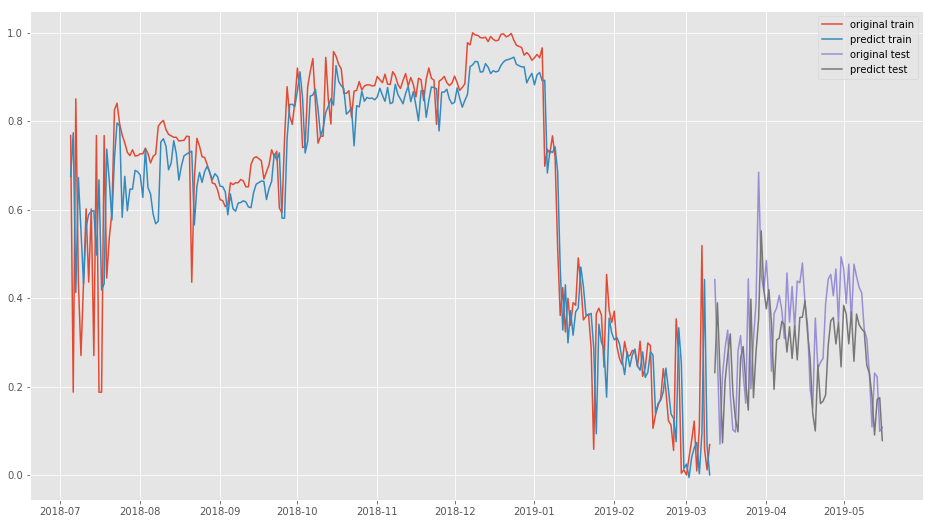

In [35]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], y_tr1,        label='original train')
plt.plot(w2['date'][1:250], y_train_pred, label='predict train')
plt.plot(w2['date'][251:], y_te1,         label='original test')
plt.plot(w2['date'][251:], y_test_pred,   label='predict test')
plt.legend()
plt.show()

In [36]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te1), MAPE(y_test_pred, y_te1)))

MSE: 0.0159 | MAPE: 0.5128


In [144]:
# whft.save('whft-loss-0.0159.hdf5')

In [132]:
# whft = load_model('whft-loss-0.0119.hdf5')

y_train_pred = whft.predict(X_tr1)
y_test_pred = whft.predict(X_te1)

y_hat = inverse(scaler, X_te1[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr1[:, :-1], y_train_pred)

In [136]:
predict_train_set = pd.DataFrame({'date': w2['date'][1:250].values,
                                  'orig': mtrain['whft'][1:250].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w2['date'][251:].values,
                                 'orig': mtest['whft'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whft_train.dat', index=False)
predict_test_set.to_csv('whft_test.dat', index=False)

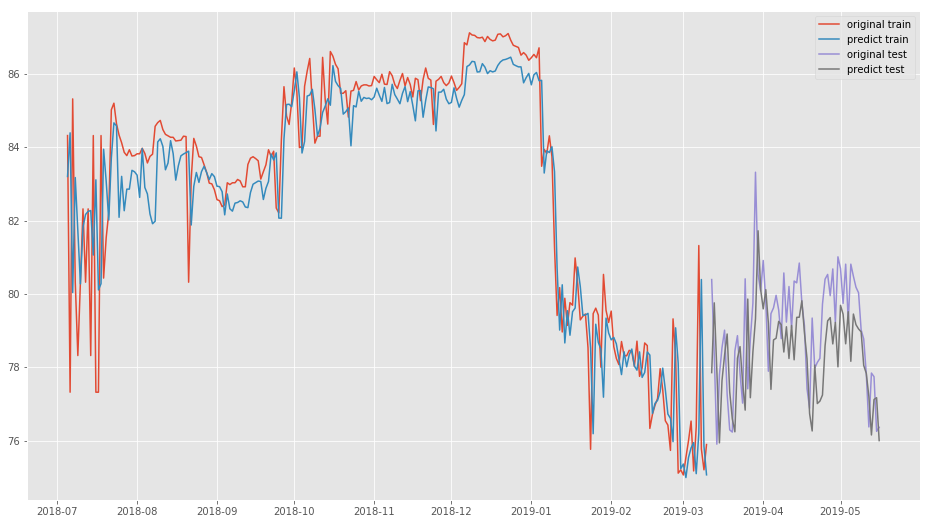

In [133]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], mtrain['whft'][1:250], label='original train')
plt.plot(w2['date'][1:250], y_train_hat,           label='predict train')
plt.plot(w2['date'][251:],  mtest['whft'][1:],     label='original test')
plt.plot(w2['date'][251:],  y_hat,                 label='predict test')
plt.legend()
plt.show()

In [134]:
m = inverse(scaler, X_te1[:, :-1], y_te1)

In [135]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 2.3187 | MAPE: 0.0152


## WHFP

In [137]:
train1 = pd.concat([mtrain.drop(['whfp'], axis=1), mtrain['whfp']], axis=1)
test1 = pd.concat([mtest.drop(['whfp'], axis=1), mtest['whfp']], axis=1)

In [138]:
scaler, train, test = scale(train1, test1)
cols = train1.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(250, 6) (67, 6)


In [139]:
vf_whfp = test.values[-1].reshape((1, -1))
vf_whfp

array([[-0.1080062 , -0.05594406,  0.68692978,  0.05249917,  0.10779436,
         0.9882789 ]])

In [140]:
X_tr2, y_tr2 = shift(train, 'whfp', step=1)
X_te2, y_te2 = shift(test, 'whfp', step=1)
print(X_tr2.shape, y_tr2.shape, X_te2.shape, y_te2.shape)

(249, 6) (249,) (66, 6) (66,)


In [113]:
m2 = Sequential()
m2.add(Dense(7, input_shape=(6, ), activation='linear'))
m2.add(LeakyReLU(alpha=0.001))
m2.add(Dense(1))
m2.compile(loss='mse', optimizer='adam')

In [114]:
epochs=60

h2 = m2.fit(X_tr2, y_tr2, 
             epochs=epochs,
             batch_size=6)

Epoch 1/60
249/249 [==============================] - 1s 4ms/step - loss: 0.4492
Epoch 2/60
249/249 [==============================] - 0s 365us/step - loss: 0.2900
Epoch 3/60
249/249 [==============================] - 0s 397us/step - loss: 0.1263
Epoch 4/60
249/249 [==============================] - 0s 389us/step - loss: 0.0466
Epoch 5/60
249/249 [==============================] - 0s 389us/step - loss: 0.0284
Epoch 6/60
249/249 [==============================] - 0s 369us/step - loss: 0.0263
Epoch 7/60
249/249 [==============================] - 0s 381us/step - loss: 0.0250
Epoch 8/60
249/249 [==============================] - 0s 365us/step - loss: 0.0242
Epoch 9/60
249/249 [==============================] - 0s 381us/step - loss: 0.0235
Epoch 10/60
249/249 [==============================] - 0s 365us/step - loss: 0.0230
Epoch 11/60
249/249 [==============================] - ETA: 0s - loss: 0.023 - 0s 369us/step - loss: 0.0226
Epoch 12/60
249/249 [==============================] - 0s 361us

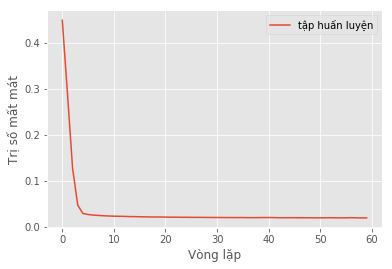

In [145]:
plt.plot(h2.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [146]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
    'loss': h2.history['loss']})
loss.to_csv('w2-whfp-loss.dat', index=False)

In [117]:
whfp = m2

y_train_pred = whfp.predict(X_tr2)
y_test_pred = whfp.predict(X_te2)

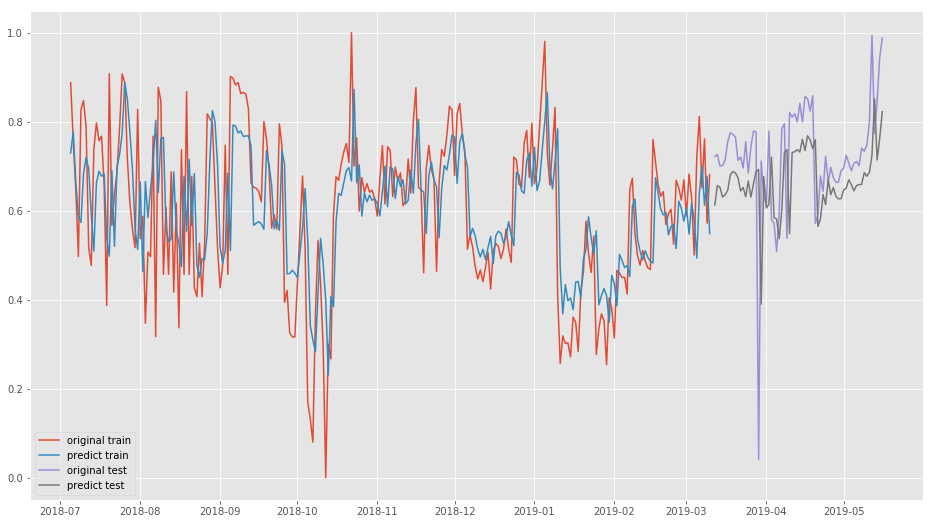

In [118]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], y_tr2,        label='original train')
plt.plot(w2['date'][1:250], y_train_pred, label='predict train')
plt.plot(w2['date'][251:], y_te2,         label='original test')
plt.plot(w2['date'][251:], y_test_pred,   label='predict test')
plt.legend()
plt.show()

In [119]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te2), MAPE(y_test_pred, y_te2)))

MSE: 0.0182 | MAPE: 0.3716


In [120]:
whfp.save('whfp-loss-0.0182.hdf5')

In [141]:
whfp = load_model('whfp-loss-0.0182.hdf5')

y_train_pred = whfp.predict(X_tr2)
y_test_pred = whfp.predict(X_te2)

y_hat = inverse(scaler, X_te2[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr2[:, :-1], y_train_pred)

In [142]:
predict_train_set = pd.DataFrame({'date': w2['date'][1:250].values,
                                  'orig': mtrain['whfp'][1:250].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w2['date'][251:].values,
                                 'orig': mtest['whfp'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whfp_train.dat', index=False)
predict_test_set.to_csv('whfp_test.dat', index=False)

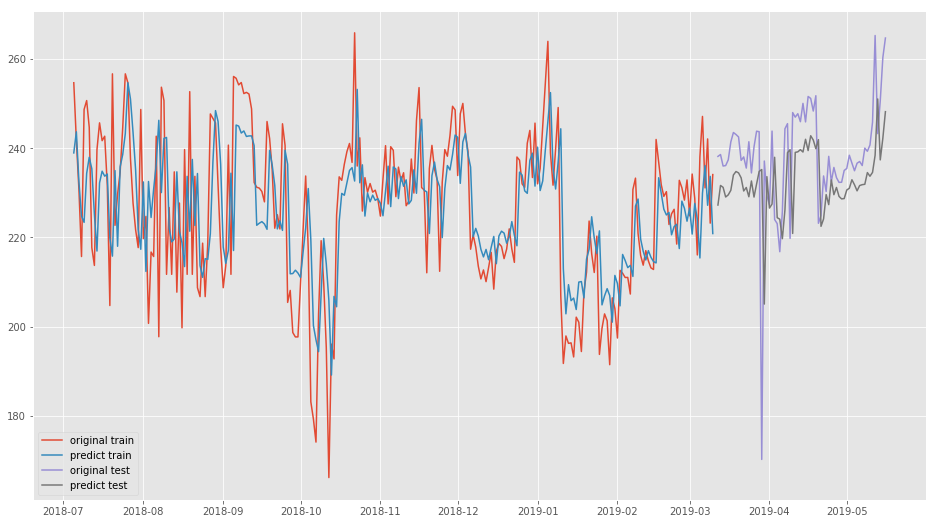

In [143]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], mtrain['whfp'][1:250], label='original train')
plt.plot(w2['date'][1:250], y_train_hat,           label='predict train')
plt.plot(w2['date'][251:],  mtest['whfp'][1:],     label='original test')
plt.plot(w2['date'][251:],  y_hat,                 label='predict test')
plt.legend()
plt.show()

In [124]:
m = test1['whfp'][:-1].values

In [125]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 60.3010 | MAPE: 0.0270


## WATER RATE

In [147]:
train2 = pd.concat([mtrain.drop(['q_water'], axis=1), mtrain['q_water']], axis=1)
test2 = pd.concat([mtest.drop(['q_water'], axis=1), mtest['q_water']], axis=1)

In [148]:
scaler, train, test = scale(train2, test2)
cols = train2.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(250, 6) (67, 6)


In [149]:
vf_water = test.values[-1].reshape((1, -1))
vf_water

array([[-0.1080062 , -0.05594406,  0.05249917,  0.9882789 ,  0.10779436,
         0.68692978]])

In [150]:
X_tr3, y_tr3 = shift(train, 'q_water', step=1)
X_te3, y_te3 = shift(test, 'q_water', step=1)
print(X_tr3.shape, y_tr3.shape, X_te3.shape, y_te3.shape)

(249, 6) (249,) (66, 6) (66,)


In [157]:
m3 = Sequential()
m3.add(Dense(7, input_shape=(6, ), activation='linear'))
m3.add(LeakyReLU(alpha=0.001))
m3.add(Dense(1))
m3.compile(loss='mse', optimizer='adam')

In [158]:
epochs = 50
h3 = m3.fit(X_tr3, y_tr3, 
             epochs=epochs,
             batch_size=6)

Epoch 1/50
249/249 [==============================] - 1s 5ms/step - loss: 0.2006
Epoch 2/50
249/249 [==============================] - 0s 466us/step - loss: 0.0945
Epoch 3/50
249/249 [==============================] - 0s 413us/step - loss: 0.0506
Epoch 4/50
249/249 [==============================] - 0s 397us/step - loss: 0.0280
Epoch 5/50
249/249 [==============================] - 0s 405us/step - loss: 0.0190
Epoch 6/50
249/249 [==============================] - 0s 373us/step - loss: 0.0155
Epoch 7/50
249/249 [==============================] - 0s 377us/step - loss: 0.0136
Epoch 8/50
249/249 [==============================] - ETA: 0s - loss: 0.015 - 0s 397us/step - loss: 0.0125
Epoch 9/50
249/249 [==============================] - 0s 409us/step - loss: 0.0116
Epoch 10/50
249/249 [==============================] - 0s 385us/step - loss: 0.0107
Epoch 11/50
249/249 [==============================] - 0s 425us/step - loss: 0.0099
Epoch 12/50
249/249 [==============================] - 0s 397us

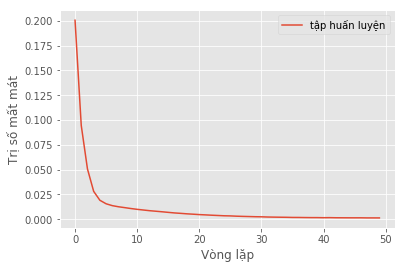

In [159]:
plt.plot(h3.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [160]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
    'loss': h3.history['loss']})
loss.to_csv('w2-water-rate-loss.dat', index=False)

In [161]:
water = m3

y_train_pred = water.predict(X_tr3)
y_test_pred = water.predict(X_te3)

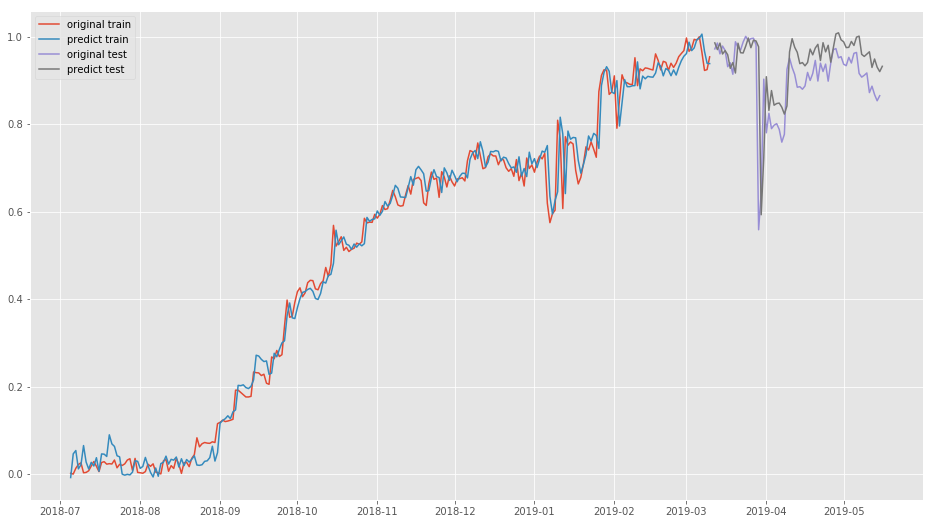

In [164]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], y_tr3,        label='original train')
plt.plot(w2['date'][1:250], y_train_pred, label='predict train')
plt.plot(w2['date'][251:-1], y_te3[:-1],         label='original test')
plt.plot(w2['date'][251:], y_test_pred,   label='predict test')
plt.legend()
plt.show()

In [163]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te3), MAPE(y_test_pred, y_te3)))

MSE: 0.0065 | MAPE: 0.0990


In [165]:
water.save('water-rate-loss-0.0065.hdf5')

In [166]:
# whfp = load_model('whfp-loss-0.016.hdf5')

y_train_pred = water.predict(X_tr3)
y_test_pred = water.predict(X_te3)

y_hat = inverse(scaler, X_te3[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr3[:, :-1], y_train_pred)

In [167]:
predict_train_set = pd.DataFrame({'date': w2['date'][1:250].values,
                                  'orig': mtrain['q_water'][1:250].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w2['date'][251:].values,
                                 'orig': mtest['q_water'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('water_train.dat', index=False)
predict_test_set.to_csv('water_test.dat', index=False)

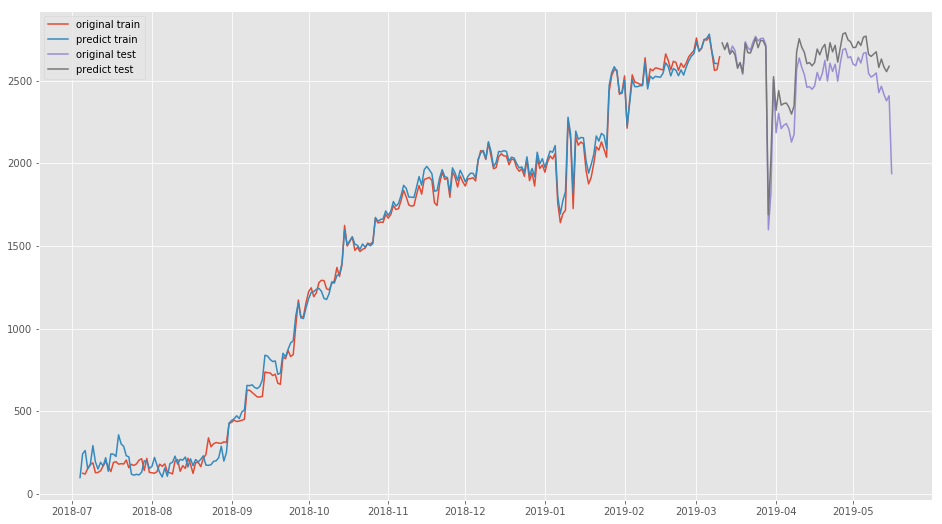

In [168]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], mtrain['q_water'][1:250], label='original train')
plt.plot(w2['date'][:249], y_train_hat,              label='predict train')
plt.plot(w2['date'][251:],  mtest['q_water'][1:], label='original test')
plt.plot(w2['date'][250:-1],  y_hat, label='predict test')
plt.legend()
plt.show()

In [169]:
m = test2['q_water'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 12519.6910 | MAPE: 0.0397


In [170]:
np.sqrt(mse(y_hat, m))

111.89142526798149

## OIL RATE

In [171]:
train3 = pd.concat([mtrain.drop(['q_oil'], axis=1), mtrain['q_oil']], axis=1)
test3 = pd.concat([mtest.drop(['q_oil'], axis=1), mtest['q_oil']], axis=1)

In [172]:
scaler, train, test = scale(train3, test3)
cols = train3.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(250, 6) (67, 6)


In [173]:
vf_oil = test.values[-1].reshape((1, -1))
vf_oil

array([[-0.05594406,  0.68692978,  0.05249917,  0.9882789 ,  0.10779436,
        -0.1080062 ]])

In [174]:
X_tr4, y_tr4 = shift(train, 'q_oil', step=1)
X_te4, y_te4 = shift(test, 'q_oil', step=1)
print(X_tr4.shape, y_tr4.shape, X_te4.shape, y_te4.shape)

(249, 6) (249,) (66, 6) (66,)


In [175]:
m4 = Sequential()
m4.add(Dense(7, input_shape=(6, ), activation='linear'))
m4.add(LeakyReLU(alpha=0.001))
m4.add(Dense(1))
m4.compile(loss='mse', optimizer='adam')

In [176]:
epochs = 60
h4 = m4.fit(X_tr4, y_tr4, 
             epochs=epochs,
             batch_size=4)

Epoch 1/60
249/249 [==============================] - 1s 5ms/step - loss: 0.2277
Epoch 2/60
249/249 [==============================] - 0s 566us/step - loss: 0.0975
Epoch 3/60
249/249 [==============================] - 0s 618us/step - loss: 0.0632
Epoch 4/60
249/249 [==============================] - 0s 630us/step - loss: 0.0430
Epoch 5/60
249/249 [==============================] - 0s 582us/step - loss: 0.0292
Epoch 6/60
249/249 [==============================] - 0s 594us/step - loss: 0.0206
Epoch 7/60
249/249 [==============================] - 0s 614us/step - loss: 0.0152
Epoch 8/60
249/249 [==============================] - 0s 646us/step - loss: 0.0125
Epoch 9/60
249/249 [==============================] - 0s 835us/step - loss: 0.0111
Epoch 10/60
249/249 [==============================] - 0s 610us/step - loss: 0.0098
Epoch 11/60
249/249 [==============================] - 0s 702us/step - loss: 0.0088
Epoch 12/60
249/249 [==============================] - 0s 549us/step - loss: 0.0081
Epo

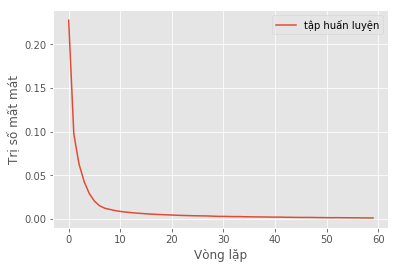

In [177]:
plt.plot(h4.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [178]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
    'loss': h4.history['loss']})
loss.to_csv('w2-oil-rate-loss.dat', index=False)

In [179]:
oil = m4

y_train_pred = oil.predict(X_tr4)
y_test_pred = oil.predict(X_te4)

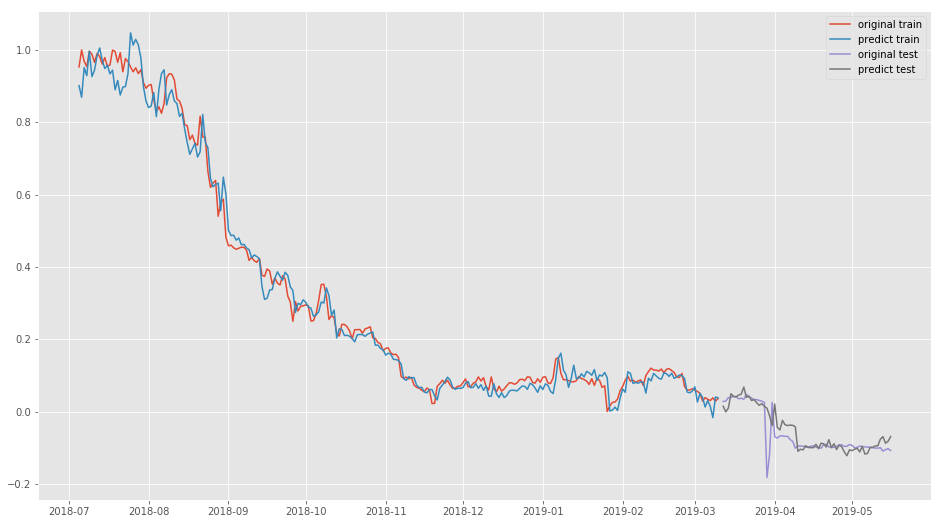

In [180]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], y_tr4, label='original train')
plt.plot(w2['date'][1:250], y_train_pred, label='predict train')
plt.plot(w2['date'][251:], y_te4, label='original test')
plt.plot(w2['date'][251:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [181]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te4), MAPE(y_test_pred, y_te4)))

MSE: 0.0013 | MAPE: 1.1273


In [182]:
oil.save('oil-rate-loss-0.0013.hdf5')

In [183]:
# oil = load_model('oil-rate-loss-0.0013.hdf5')

y_train_pred = oil.predict(X_tr4)
y_test_pred = oil.predict(X_te4)

y_hat = inverse(scaler, X_te4[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr4[:, :-1], y_train_pred)

In [184]:
predict_train_set = pd.DataFrame({'date': w2['date'][1:250].values,
                                  'orig': mtrain['q_oil'][1:250].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w2['date'][251:].values,
                                 'orig': mtest['q_oil'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('oil_train.dat', index=False)
predict_test_set.to_csv('oil_test.dat', index=False)

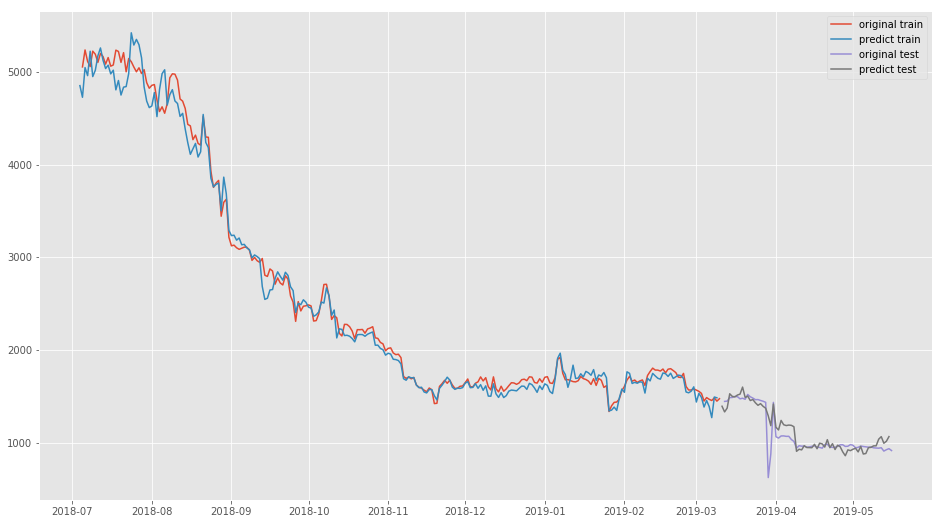

In [185]:
plt.figure(figsize=(16, 9))
plt.plot(w2['date'][1:250], mtrain['q_oil'][1:250], label='original train')
plt.plot(w2['date'][:249], y_train_hat, label='predict train')
plt.plot(w2['date'][251:],  mtest['q_oil'][1:], label='original test')
plt.plot(w2['date'][250:-1],  y_hat, label='predict test')
plt.legend()
plt.show()

In [186]:
m = test3['q_oil'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 12777.6121 | MAPE: 0.0702


## PREDICT

In [7]:
whft = load_model('whft-loss-0.0119.hdf5')
pred = whft.predict(vf_whft)
whft_future = inverse(scaler, vf_whft[:, :-1], pred)

In [8]:
whft_future

array([77.73512113])

In [17]:
whfp = load_model('whfp-loss-0.016.hdf5')
pred = whfp.predict(vf_whfp)
whfp_future = inverse(scaler, vf_whfp[:, :-1], pred)

In [18]:
whfp_future

array([248.14274022])

In [22]:
water = load_model('water-rate-loss-0.0051.hdf5')
pred = water.predict(vf_water)
water_rate_future = inverse(scaler, vf_water[:, :-1], pred)

In [23]:
water_rate_future

array([2132.73962726])

In [54]:
oil = load_model('oil-rate-loss-0.0011.hdf5')
pred = oil.predict(vf_oil)
oil_rate_future = inverse(scaler, vf_oil[:, :-1], pred)

In [55]:
oil_rate_future

array([977.96934031])

In [187]:
t = whft.layers[2].get_weights()[0].reshape((1, -1))
p = whfp.layers[2].get_weights()[0].reshape((1, -1))
qw = water.layers[2].get_weights()[0].reshape((1, -1))
qo = oil.layers[2].get_weights()[0].reshape((1, -1))
weight = np.r_[qo, qw, t, p]
bias = np.r_[oil.layers[2].get_weights()[1], water.layers[2].get_weights()[1],\
             whft.layers[2].get_weights()[1], whfp.layers[2].get_weights()[1]].reshape((-1, 1))
q = np.c_[weight, bias]
x = pd.DataFrame(data=q, columns=['1', '2', '3', '4', '5', '6', '7', 'bias'])

In [189]:
x.to_csv('w2-weight.csv', index=False)